In [23]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from dare import Riccati
from data_gen import generate_simulated_data
from device import device
from env_setup import *
from models import ThetaEstimatorTransformer

In [24]:
# Generate trajectories to train estimator
sim_policy = dict()
sim_policy['human_state'] = 'varying'  # can be 'fixed' or 'varying'
sim_policy['mental_state'] = 'fixed'  # can be 'fixed' or 'varying'

sim_time = 20
n_demo = 5
human_mode = 'gradient_descent'  # can also be 'gradient_descent_threshold'

data = generate_simulated_data(sim_policy, sim_time, n_demo, human_mode)
robot_states, human_actions, human_obs, human_mental_states = data

100%|██████████| 5/5 [00:00<00:00, 67.05it/s]


### Visualize simulated human trajectories

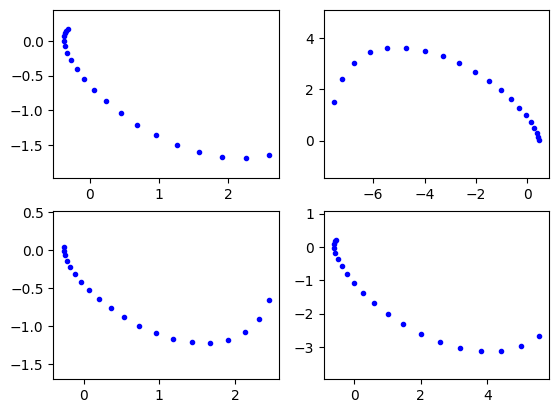

In [25]:
n = 2 if (n_demo < 9) else 3
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        human_traj = np.array(robot_states[idx]).squeeze()
        ax.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=3)
        ax.axis(xmin=-1, xmax=1, ymin=-1, ymax=1)
        ax.axis('equal')

### Visualize simulated human internal models

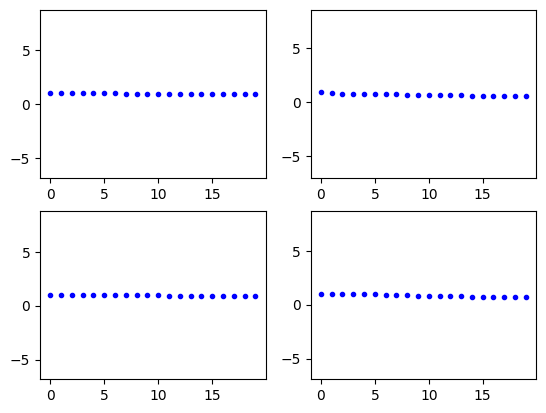

In [28]:
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        human_internal_state_traj = np.array(human_mental_states[idx]).squeeze()
        ax.plot(human_internal_state_traj, 'bo', markersize=3)
        ax.set_ylim([-2.0, 2.0])
        ax.axis('equal')

### Pre-processing trajectory data for estimator

In [16]:
states = torch.tensor(robot_states, device=device)
states = states.view(n_demo * sim_time, nX)

actions = torch.tensor(human_actions, device=device)
actions = actions.view(n_demo * sim_time, nU)

inputs = torch.cat((states, actions), axis=1)
inputs = inputs.view(n_demo, sim_time, nX + nU).double()
print(inputs.shape)

torch.Size([10, 20, 3])


### Train $\theta_H$ estimator E2E with LQR

In [17]:
EPOCHS = 100

transformer_estimator = ThetaEstimatorTransformer().to(device).double()
transformer_estimator.train()
optimizer = torch.optim.Adam(transformer_estimator.parameters(), lr=10.0)

In [18]:
def predict_action(state, theta_H):
    B_hat_tensor = theta_H * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.linalg.multi_dot((
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.linalg.multi_dot((torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor))
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    ))
    action_pred = torch.neg(torch.matmul(K, state))
    return action_pred

def transformer_step(model, inputs):
    inputs = inputs.reshape(-1, inputs.shape[0], inputs.shape[1])
    theta_Hs = model(inputs)
    theta_Hs = theta_Hs.reshape(sim_time)

    step_losses = []
    for i in range(sim_time - 1):
        theta_H = theta_Hs[i]
        input = inputs[0][i]
        state, action = torch.split(input, [2, 1])
        
        action_pred = predict_action(state, theta_H)
        loss_fn = nn.MSELoss()
        loss = loss_fn(action_pred, action)
        step_losses.append(loss)
    
    optimizer.zero_grad()
    step_loss = sum(step_losses)
    step_loss.backward()
    optimizer.step()
    
    return loss.data.item(), theta_H.data.item()

100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s]


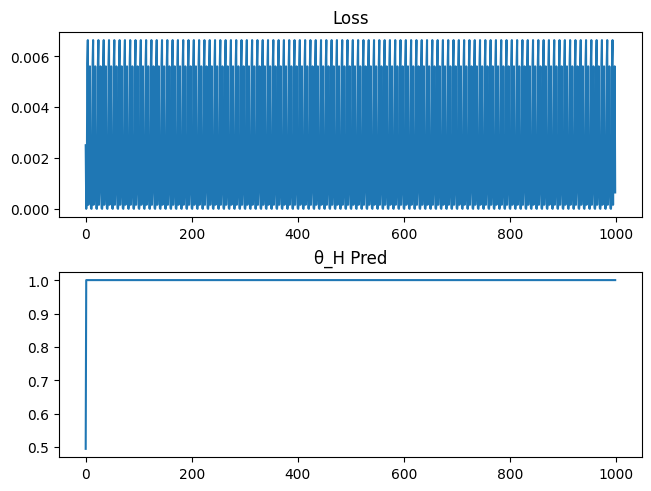

In [19]:
loss_list, theta_H_list = [], []
for epoch in tqdm(range(EPOCHS * n_demo)):
    curr_demo_idx = epoch % n_demo
    curr_demo = inputs[curr_demo_idx]
    loss, theta_H = transformer_step(transformer_estimator, curr_demo)
    loss_list.append(loss)
    theta_H_list.append(theta_H)

fig, axs = plt.subplots(2, constrained_layout=True)
axs[0].plot(range(EPOCHS * n_demo), loss_list)
axs[1].plot(range(EPOCHS * n_demo), theta_H_list)
axs[0].title.set_text('Loss')
axs[1].title.set_text('θ_H Pred')